# Linear regression models 



## Simple (univariate) linear regression

Imagine the simplest linear model where the dependent variable $y$ is
assumed to be an affine function of the explanatory variable $x$
and an error term $\epsilon$,
$$
y_i = \alpha + \beta x_i + \epsilon_i
$$
The parameter $\alpha$ and $\beta$ are called the intercept and
slope parameters in econometrics. In machine learning, the terminology
often differs and you might see a simple linear model written like
$$
y_i = b + w x_i + \epsilon_i
$$
where $b$ is called the *bias* and $w$ is called as *weight*. 

Our goal is to estimate the parameters $\alpha$ and $\beta$ which is
most commonly done by ordinary least squares (OLS). OLS is defined as the
estimator that finds the estimates $(\widehat{\alpha}, \widehat{\beta})$
such that the sum of squared errors is minimized,
$$
L(\alpha, \beta) = \frac{1}{N}
    \sum_i^N \Bigl(y_i - \alpha - \beta x_i \Bigr)^2
$$
where $L$ is the loss function that depends on the choice parameters. Note that
we use the "hat" notation $\widehat{\alpha}$ to distinguish the OLS
estimate from the (usually unknown) true parameter $\alpha$. The exact
value of $\widehat{\alpha}$ will vary based on the estimator used as we
will see later in this unit.

For this simple model, the estimates are given by
$$
\begin{aligned}
\widehat{\beta} &= \frac{\widehat{Cov}(y,x)}{\widehat{Var}(x)} \\
\widehat{\alpha} &= \overline{y} - \widehat{\beta} \overline{x}
\end{aligned}
$$
where $\widehat{Cov}(\bullet,\bullet)$ and $\widehat{Var}(\bullet)$ are the *sample* covariance and
variance, respectively, and $\overline{y}$ and $\overline{x}$ are the sample
means of $y$ and $x$. 

There is a straightforward generalization to
the multivariate setting where we have a vector of explanatory variables 
$\mathbf{x}_i$ (which usually include the intercept) and a parameter vector
$\bm\beta$ so that the model is given by
$$
y_i = \mathbf{x}_i'\bm\beta + \epsilon_i
$$
If we stack all $\mathbf{x}_i$ in the matrix $\mathbf{X}$ and all $y_i$ in 
the vector $\mathbf{y}$, the OLS estimate 
of $\bm\beta$ is given by the well-known formula
$$
\widehat{\bm\beta} = \left(\mathbf{X}'\mathbf{X}\right)^{-1} \mathbf{X}'\mathbf{y}
$$

However, we will not be estimating linear regressions based on this formula and you should never attempt this, as naively implementing such matrix operations can lead to numerical problems. Instead, always use pre-packaged least-squares solvers such as those implemented in NumPy's [`lstsq()`](https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html) or
SciPy's [`lstsq()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html). For econometrics and machine learning, it usually makes sense to use linear regression models such as those implemented in 
[`statsmodels`](https://www.statsmodels.org/stable/regression.html) or
[`scikit-learn`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html),
which is what we turn to next.

### Univariate linear regressions with scikit-learn

In [25]:
import numpy as np
from numpy.random import default_rng


rng = default_rng(123)

# Number of observations
N = 50

alpha = 1.0
beta = 0.5

x = np.linspace(0, 10, N)
epsilon = rng.normal(scale=0.7, size=N)
y = alpha + beta * x + epsilon

In [26]:
from sklearn.linear_model import LinearRegression

# Create LinearRegression object
lr = LinearRegression(fit_intercept=True)

# fit() expects two-dimensional object, convert to N x 1 matrix
X = x[:, None]

# Fit model to data
lr.fit(X, y)

# Predict fitted values
yhat = lr.predict(X)

Text(0.5, 0.98, 'Univariate linear regression')

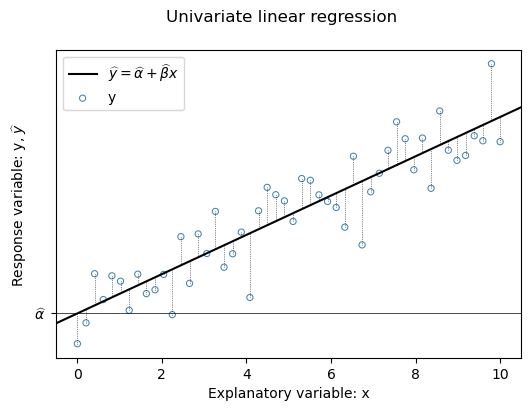

In [28]:
import matplotlib.pyplot as plt

# Extract parameter estimates from LinearRegression object
alpha_hat = lr.intercept_
beta_hat = lr.coef_[0]

def plot_univariate_reg(intercept, slope, X=None, y=None, color='steelblue'):

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))

    # Plot regression line
    ax.axline((0.0, intercept), slope=slope, lw=1.5, c='black', 
        label=r'$\widehat{y} = \widehat{\alpha} + \widehat{\beta} x$')

    if X is not None and y is not None:
        # Make sure x is 1d-array
        x = X.flatten()

        # Plot raw data
        ax.scatter(x, y, s=20, color='none', edgecolor=color, alpha=1.0, 
            lw=0.75, label='y')

        # Plot lines connecting true and predicted values for 
        # each observation
        for i in range(len(x)):
            # Predict yhat for given x_i
            yhat_i = intercept + slope * x[i]
            ax.plot([x[i], x[i]], [y[i], yhat_i], lw=0.5, ls=':', 
                c='black', alpha=0.9)

    # Add annotations
    ax.set_xlabel('Explanatory variable: x')
    ax.set_ylabel(r'Response variable: y, $\widehat{y}$')
    ax.axhline(intercept, lw=0.5, c='black')
    ax.legend(loc='best')
    ax.set_yticks((intercept, ), (r'$\widehat{\alpha}$', ))

plot_univariate_reg(alpha_hat, beta_hat, X, y)
plt.gcf().suptitle('Univariate linear regression')


### Training and test samples

In econometrics, we usually emphasise *inference*, i.e., we are interested in testing a hypothesis about the estimated parameter, for example whether it is statistically different from zero. Conversely, in machine learning the emphasis is often on prediction, i.e., our goal is to estimate a relationship from a *training* sample and make predictions for new data. Usually, we use a *test* sample that is different from the to assess how well our model is able to predict outcomes for new data which has not been used for estimation.

To demonstrate the use of training and test data sets, we will use the 
[Ames house price data set](https://www.openml.org/d/42165) 
which can be obtained from [openml.org](https://www.openml.org), a repository for free-to-use data sets suitable for machine learning tasks.

The original data set has 80 features (explanatory variables) which are house characteristics of houses in Ames, a city of about 60 thousand inhabitants in the middle of Iowa, USA. The goal is to use these features to predict the house prices (or "target" in ML terminology). The above website provides details on all 80 features, but we will restrict ourselves to a small subset.

We could download the data set directly from [openml.org](https://www.openml.org) using `scikit-learn` as follows:
```python
    from sklearn.datasets import fetch_openml
    ds = fetch_openml(name='house_prices')

    X = ds.data         # Get features (explanatory variables)
    y = ds.target       # get dependent variable
```
which returns an object with various information about the data set. The features are stored in the `data` attribute, while the dependent variable is stored in the `target` attribute.

Instead, we will use a local copy of the data set which contains only a subset of 13 features. 

In [50]:
import pandas as pd

# Uncomment this to use files in the local data/ directory
DATA_PATH = '../data'

# Load data directly from GitHub (for Google Colab)
# DATA_PATH = 'https://raw.githubusercontent.com/richardfoltyn/MLFP-ECON5130/main/data'

df = pd.read_csv(f'{DATA_PATH}/ames_houses.csv')


In [51]:
# List columns present in DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   SalePrice     1460 non-null   int64 
 1   LotArea       1460 non-null   int64 
 2   Neighborhood  1460 non-null   object
 3   BldgType      1460 non-null   object
 4   OverallQual   1460 non-null   int64 
 5   OverallCond   1460 non-null   int64 
 6   YearBuilt     1460 non-null   int64 
 7   CentralAir    1460 non-null   object
 8   GrLivArea     1460 non-null   int64 
 9   FullBath      1460 non-null   int64 
 10  BedroomAbvGr  1460 non-null   int64 
 11  Fireplaces    1460 non-null   int64 
 12  GarageType    1379 non-null   object
 13  YrSold        1460 non-null   int64 
dtypes: int64(10), object(4)
memory usage: 159.8+ KB


In [52]:
features = ['GrLivArea']
target = 'SalePrice'

y = df[target].to_numpy()
X = df[features].to_numpy()

We next want to split the data set intro training and test sub-samples. We do this by randomly selecting a desired fraction of the data to be part of the training sample and assign the rest to the test sample.

In [53]:
import numpy as np
from numpy.random import default_rng

rng = default_rng(123)

# sample size
N = len(y)

# fraction of data used for test sample
test_size = 0.1

# training and test sample sizes
N_test = int(N * test_size)
N_train = N - N_test

# Randomly assign observations to training or test samples
itrain = rng.choice(np.arange(N), size=N_train, replace=False)
# Test sample is complement to training sample
itest = np.setdiff1d(np.arange(N), itrain)

# Select training sample
X_train = X[itrain]
y_train = y[itrain]

# Select test sample
X_test = X[itest]
y_test = y[itest]

In [54]:
from sklearn.linear_model import LinearRegression

# Fit model on training sample
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict model for test sample
y_test_hat = lr.predict(X_test)

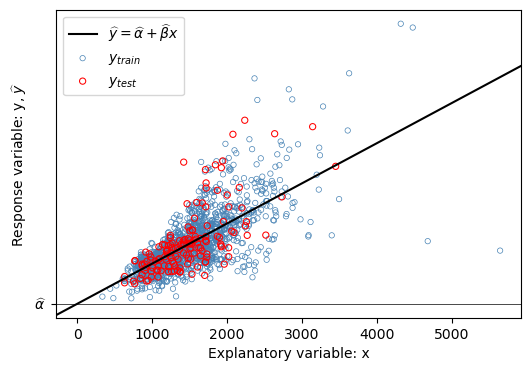

In [55]:
intercept = lr.intercept_
slope = lr.coef_[0]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# Plot regression line
ax.axline((0.0, intercept), slope=slope, lw=1.5, c='black', 
    label=r'$\widehat{y} = \widehat{\alpha} + \widehat{\beta} x$')

# Plot training data
ax.scatter(X_train, y_train, s=15, color='none', edgecolor='steelblue', 
    alpha=1.0, lw=0.5, label=r'$y_{train}$')

# Plot test data
ax.scatter(X_test, y_test, s=20, color='none', edgecolor='red', 
    alpha=1.0, lw=0.75, label=r'$y_{test}$')

# Add annotations
ax.set_xlabel('Explanatory variable: x')
ax.set_ylabel(r'Response variable: y, $\widehat{y}$')
ax.axhline(intercept, lw=0.5, c='black')
ax.legend(loc='best')
ax.set_yticks((intercept, ), (r'$\widehat{\alpha}$', ))



In [56]:
y.shape

(1460,)

In [57]:
from sklearn.model_selection import train_test_split



## Multivariate linear regression

Multivariate linear regression extends the simple model to multiple explanatory variables or regressors. 

In [58]:
features = ['GrLivArea', 'LotArea', 'OverallQual', 'OverallCond']
target = 'SalePrice'

X = df[features].to_numpy()
y = df[target].to_numpy()

In [59]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)





LinearRegression()